# Hotwheels ML

Let's race!
Your goal is to predict which of these cars will finish the track in the shortest amount of time.

You are provided an additional set of 79 entries to use for your Machine Learning magic. Good luck!

In [35]:
%matplotlib inline
import pandas as pd
import pprint
df_competition = pd.read_csv('competition-hotwheels.csv')
df_competition

model  year primary_color  detail  mass  length  width  \
0  hammered coupe  2000        purple     NaN    38    8.63   3.11   
1       shredster  2000        orange     NaN    43    8.16   3.10   
2          bedlam  2003         green     NaN    29    7.53   3.00   
3    mach speeder  2017        purple    blue    26    7.17   3.28   
4  jet threat 3.0  2000        silver     NaN    38    8.91   3.11   
5       67 camaro  2016         brown  flames    30    6.84   2.84   
6   midnight otto  2001         white  orange    44    6.21   3.00   

   height_above_front_wheel  peak_height  height_above_back_wheel  \
0                      1.00         1.80                     1.70   
1                      1.37         1.85                     1.08   
2                      1.29         2.10                     1.50   
3                      1.22         1.81                     1.80   
4                      1.00         1.55                     1.40   
5                      1.40         2.07                     1.92   
6                      1.59         2.50                     2.50   

   avg_wheel_width  avg_wheel_diameter  num_wheels wheel_type  flat_wheels  \
0              0.6                 1.1           4        5SP            1   
1              0.6                 1.1           4        PR5            1   
2              0.6                 1.1           4      5SP-C            1   
3              0.5                 1.0           4      TRAP5            1   
4              0.5                 1.1           4       5DOT            1   
5              0.5                 1.1           4        5SP            1   
6              0.5                 1.1           4        PR5            1   

   metal_base  metal_body  spoiler  
0           1           1        0  
1           0           1        1  
2           1           0        0  
3           0           1        1  
4           1           1        0  
5           0           1        0  
6           1           1        0

<img src="img/competition-hotwheels.png" width=1000 height=60 />

Feel free to use the existing code here as a starting point.

Some suggested improvements:
- Tweak parameters on your favorite classification/regression models to minimize error
- Update the script so that it aggregates predictions from multiple regression and/or classification models 

## Setup

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Data Preparation

In [37]:
df = pd.read_csv('hotwheels.csv')
df = shuffle(df)

def set_types(df):
    # Pandas does a decent job guessing data types, but let's clean it up.
    df['flat_wheels'] = df['flat_wheels'].astype(bool)
    df['metal_base'] = df['metal_base'].astype(bool)
    df['metal_body'] = df['metal_body'].astype(bool)
    df['spoiler'] = df['spoiler'].astype(bool)
    df['mass'] = df['mass'].astype(float)
    df['primary_color'] = df['primary_color'].astype("category")
    df['wheel_type'] = df['wheel_type'].astype("category")
    return df

df = set_types(df)
df['race_finished'] = df['race_result'].map(lambda x: not 'NF' in x).astype(bool)
df['race_time'] = df['race_result'].map(lambda x: None if 'NF' in x else x).astype(float)

# # Encodings
# # Get one hot encoding of wheel type column
# one_hot = pd.get_dummies(df['wheel_type'])
# # Drop column wheel type as it is now encoded
# df = df.drop('wheel_type',axis = 1)
# # Join the encoded df
# df = df.join(one_hot)

# # Get one hot encoding of wheel type column
# one_hot = pd.get_dummies(df['primary_color'])
# # Drop column wheel type as it is now encoded
# df = df.drop('primary_color',axis = 1)
# # Join the encoded df
# df = df.join(one_hot)

# Using wheel type and primary color seems to just muddy the water.
# If you want to try using them, stop removing the column here and in the prediction section.
df = df.drop(columns=['wheel_type', 'primary_color'], inplace=False)

# Model name is unnecessary and could be deceptive
# Race Result has been split up into race_finished and race_time
# Detail field is just so we can tell apart the cars from pictures
df = df.drop(columns=['model', 'race_result', 'detail'], inplace=False)

y_classification = df['race_finished']
X_classification = df.drop(columns=['race_finished', 'race_time'], inplace=False)

df_finished = df[df['race_finished'] != False]
y_regression = df_finished['race_time']
X_regression = df_finished.drop(columns=['race_finished', 'race_time'], inplace=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 41 to 26
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      79 non-null     int64  
 1   mass                      79 non-null     float64
 2   length                    79 non-null     float64
 3   width                     79 non-null     float64
 4   height_above_front_wheel  79 non-null     float64
 5   peak_height               79 non-null     float64
 6   height_above_back_wheel   79 non-null     float64
 7   avg_wheel_width           79 non-null     float64
 8   avg_wheel_diameter        79 non-null     float64
 9   num_wheels                79 non-null     int64  
 10  flat_wheels               79 non-null     bool   
 11  metal_base                79 non-null     bool   
 12  metal_body                79 non-null     bool   
 13  spoiler                   79 non-null     bool   
 14  race_finish

## Classification Training

Since we are doing KFold with 4 splits, the goal is to get all 4 values as close to 1 as possible

A large variation between the scores returned between the splits indicates your model could overfit the data.

Check out [this page](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) which you can use to get to documentation pages for each of these classifiers. (Just click the classifier name in the scikit-learn example code)

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [39]:
# Uncomment the classifier you wish to try! (Use Ctrl + /)
clf = KNeighborsClassifier(4)
# clf = DecisionTreeClassifier(max_depth=10)
# clf = KNeighborsClassifier(3),
# clf = SVC(kernel="linear", C=0.025),
# clf = SVC(gamma=2, C=1),
# clf = GaussianProcessClassifier(1.0 * RBF(1.0)),
# clf = DecisionTreeClassifier(max_depth=5),
# clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
# clf = MLPClassifier(alpha=1, max_iter=1000),
# clf = AdaBoostClassifier(),
# clf = GaussianNB(),
# clf = QuadraticDiscriminantAnalysis()

# You can also try increasing the number of splits here:
print(cross_val_score(clf, X_classification, y_classification, cv = KFold(n_splits=4)))
clf.fit(X_classification, y_classification)

[0.6        0.55       0.55       0.73684211]


KNeighborsClassifier(n_neighbors=4)

## Regression Training

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.isotonic import IsotonicRegression

In [41]:
# Uncomment the regressor you wish to try! (Use Ctrl + /)
reg = LinearRegression()
# reg = svm.SVR()
# reg = tree.DecisionTreeRegressor()
# reg = MLPRegressor(random_state=1, max_iter=1000)
# reg = MLPRegressor(random_state=1, max_iter=1000, alpha=3)
# reg = MLPRegressor(random_state=1, max_iter=1000, solver='lbfgs')

print(cross_val_score(reg, X_regression, y_regression, cv = KFold(n_splits=4)))
reg.fit(X_regression, y_regression)

[-3.22555138 -1.1529472  -0.04481164 -1.58268038]


LinearRegression()

If using a Linear Model, let's investigate the significance behind the assigned weights
Remember, **negative (not positive)** values mean that aspect may have contributed to a quicker finish (shorter time on track)

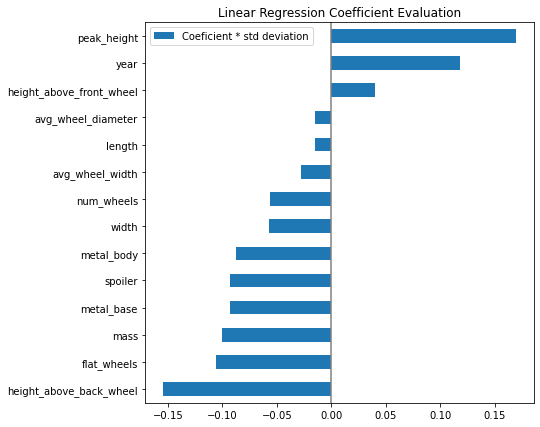

In [42]:
if isinstance(reg, LinearRegression):
    coefs = pd.DataFrame(
        reg.coef_
        * X_regression.std(axis=0),
        columns=["Coeficient * std deviation"],
        index=X_regression.columns,
    )
    coefs = coefs.sort_values(by=['Coeficient * std deviation'])
    coefs.plot(kind="barh", figsize=(9, 7))
    plt.title("Linear Regression Coefficient Evaluation")
    plt.axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)

## Predict

Now that we have our Classifier and Regression models both trained, let's run them like this:
1. Use the classifier to predict which cars will finish the track.
2. For cars finishing the track, predict how long they will take to finish.
3. Sort results according to finish order.

In [43]:
# Predict whether each car will finish
df_competition_clean = set_types(df_competition).drop(columns=['model', 'detail', 'wheel_type', 'primary_color'], inplace=False)
finish_prediction = clf.predict(df_competition_clean)

# Predict times for all cars
time_prediction = reg.predict(df_competition_clean)

# Overlay the non-finisher prediction
prediction = [time_prediction[i] if finish_prediction[i] == True else np.nan for i in range(len(finish_prediction))]

results = df_competition.copy()
results['prediction'] = prediction
results = results[['model', 'prediction']]
results.sort_values(by=['prediction'])

model  prediction
0  hammered coupe    4.211410
4  jet threat 3.0    4.248183
6   midnight otto    4.361324
1       shredster    4.398865
2          bedlam    4.979494
3    mach speeder         NaN
5       67 camaro         NaN

## Great job on the predictions! 
But which car actually won? It shall be revealed at the end of the presentation!

## Other Cool Stuff
### Classification Visualizations
This script from sklean provides a neat view into how different models handle a simplified 2-dimensional classification problem

In [44]:
# This is a 2D display, so you can only use two fields here
hotwheels_dataset_fields_to_use = ['mass', 'height_above_front_wheel']

double click to zoom


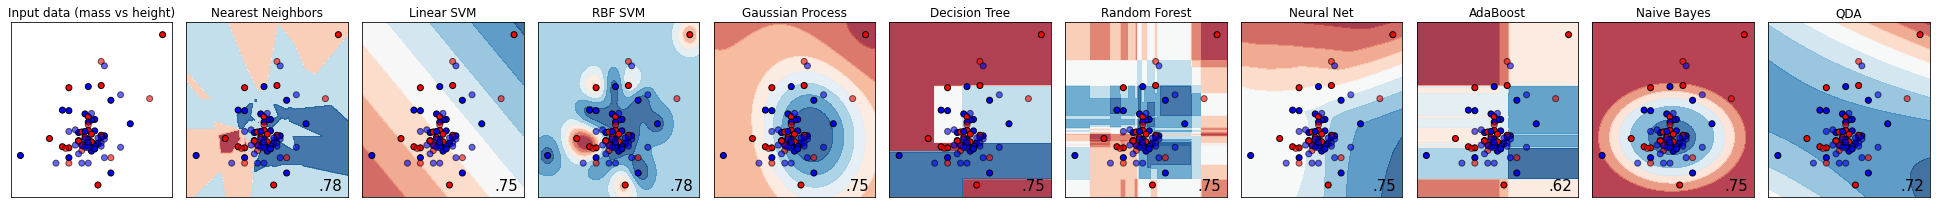

In [45]:

# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [(X_classification[hotwheels_dataset_fields_to_use], y_classification)]

figure = plt.figure(figsize=(27, 3))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data (mass vs height)")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, classifier in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(classifier, "decision_function"):
            Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
print('double click to zoom')
plt.show()

### Regression Visualizations
This script from sklean provides a neat view into how different models handle a 1-dimensional regression problem

Remember, in this visualization, you only have access to a single dimension, so a bad score isn't the end of the world

In [46]:
hotwheels_dataset_field_to_use = 'mass'
# try switching to this:
# hotwheels_dataset_field_to_use = 'height_above_front_wheel'

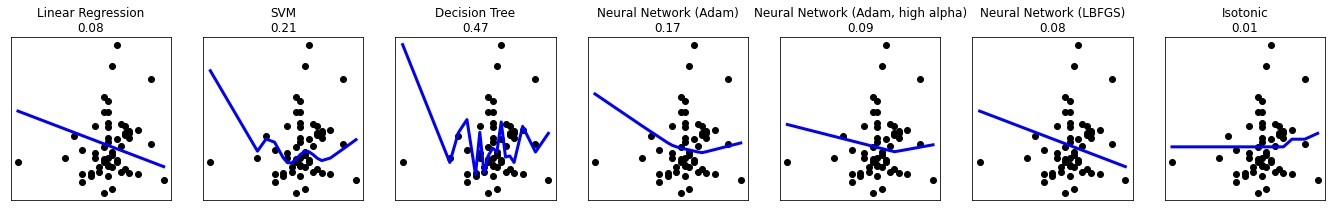

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.isotonic import IsotonicRegression

names = ["Linear Regression", "SVM", "Decision Tree", "Neural Network (Adam)", "Neural Network (Adam, high alpha)", "Neural Network (LBFGS)", "Isotonic"]

regressors = [
    LinearRegression(),
    svm.SVR(),
    tree.DecisionTreeRegressor(),
    MLPRegressor(random_state=1, max_iter=1000),
    MLPRegressor(random_state=1, max_iter=1000, alpha=3),
    MLPRegressor(random_state=1, max_iter=1000, solver='lbfgs'),
    IsotonicRegression()
]

figure = plt.figure(figsize=(27, 3))

X, y = (X_regression[[hotwheels_dataset_field_to_use]], y_regression)

i = 1
for name, regressor in zip(names, regressors):
    ax = plt.subplot(1, len(regressors) + 1, i)

    regressor.fit(X, y)
    score = regressor.score(X, y)

    # Make predictions using the testing set
    X_sorted = X.sort_values(by=[hotwheels_dataset_field_to_use])
    y_pred = regressor.predict(X_sorted)

    # Plot outputs
    plt.scatter(X_sorted, y, color='black')
    plt.plot(X_sorted, y_pred, color='blue', linewidth=3)

    plt.xticks(())
    plt.yticks(())
    ax.set_title('{}\n{}'.format(name, '%.2f' % score))
    i += 1




plt.show()